In this notebook, I try to numerically simulate the effects of an aberrated pupil function on the imaged column density using near-resonant absorption.

The simulation is laid out more or less in the following way:
- Initialize a plane wave / gaussian probe field $E_{-}$
- Create a 2D scatterer distribution at z = 0, modeled by a complex dielectric susceptibility $\chi$
- Scattered field in the dilute ensemble limit is $E_+ \approx (1 + \chi)E_-$
- Compute scattered fraction $ \delta E_- / E_- = 1 - E_+ / E_-$, e.g. derive OD etc...
- Propagate field through pupil function and add detector/photon shot noise
- Deconvolve intensity images using some simple tikhonov regularizer, e.g. just refocus 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    plt.stlye.use('pacostyle')
except:
    plt.style.use('default')
from physunits import *
from scipy.constants import hbar, c

# Script control
verbose = True

# Constants
ħ = hbar 
π = np.pi

# Atomic constants -- Rb87
λ0 = 780.24*nm                # Imaging transition wavelength 
k0 = 2 * π / λ0               # Imaging transition wavenumber
σ0 = 3 * λ0 ** 2 / (2 * π)    # Resonant scattering cross-section
Isat = 1.67 * mW / (cm ** 2)  # Saturation intensity
Γ0 = 2 * π * 6.06 * MHz       # Natural linewidth
n0 = 3e12 / (cm **3)          # Peak atomic (volume) density 
Rx, Ry = 10*um, 10*um         # Cloud radii (transverse)
Rz = 2 * um                   # Cloud's thickness (assumed thin on this notebook)

# Probe constants
I0 = 2 * Isat                  # Probe intensity
w0 = 400 * um                  # Probe beam's waist (beam radius)
δ = 2 * π * 0.0 * MHz          # Probe frequency detuning from resonance
Δ = 2 * δ / Γ0                 # "Reduced" detuning (in units of half-linewidths)

In [2]:
# Useful functions
def cart2pol(x, y):
    """ Turn cartesian to polar """
    return(np.sqrt(x**2 + y**2), np.arctan2(y, x))

def field2intensity(field):
    """ Give intensity from unnormalized complex field"""
    return np.real(field * field.conj())

def photon_shot_noise(intensity):
    """ Upon detection, shot noise gets added """
    return np.random.poisson(np.sqrt(intensity))

def atomic_line(intensity, detuning, linewidth):
    """ Two-level OBE off-diagonal element gives this analytical solution """
    saturation_par = intensity / Isat
    detuning_bar = 2 * detuning / linewidth
    return (1.0j - detuning_bar)/(1 + saturation_par + detuning_bar**2)

# Peak atomic susceptibility
χ0 = (n0 * σ0 / k0) * atomic_line(I0, δ, Γ0)

if verbose:
    # For example, what is the peak index of refraction of this cloud?
    peak_index = np.sqrt(1 + χ0)
    print(f'Peak index of refraction: {peak_index.real:3f}')

Peak index of refraction: 1.000163


In [3]:
# Construct atomic distribution grid; should be large enough to 
# acommodate some spectral leakage from aliasing during propagation
Nx, Ny = 2**11 - 1, 2**11 - 1

# Diffraction limited resolution from numerical aperture
NA = 0.30
dx, dy = 0.61 * λ0 / NA, 0.61 * λ0 / NA
kNA = 2 * π / dx

# Object plane "pixel" size, a good system should make 
# this smaller than the diffraction limited resolution
# i.e. a ccd should be able to resolve the point spread function
magnification = 11.0
pixel_size = 5.6 * um
Δx, Δy = pixel_size / magnification, pixel_size / magnification

# Image plane spatial grid (magnified object plane)
x, y = Δx*np.arange(-Nx//2, Nx//2 + 1, 1), Δy*np.arange(-Ny//2, Ny//2 + 1, 1)
X, Y = np.meshgrid(x, y)

# Reciprocal grid (object plane)
kx, ky = 2*π*np.fft.fftfreq(Nx + 1, d=Δx), 2*π*np.fft.fftfreq(Ny + 1, d=Δy)
kX, kY = np.meshgrid(kx, ky)
kR, kT = cart2pol(kX, kY)

if verbose:
    # What is the peak atom number in a grid voxel? Use 2 um for depth of field...
    dz = 2*um
    print(f'Peak atom number ~ {n0 * Δx * Δy * dz:.1f} atoms in the central voxel')

Peak atom number ~ 1.6 atoms in the central voxel


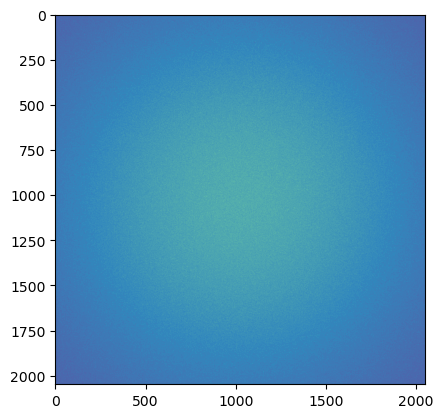

In [4]:
# Initialize probe field
E_minus = np.sqrt(I0) * np.exp(- (X**2 + Y**2) / (2*w0**2))

if verbose:
    # Show some field intensity, i.e. a probe "shot"
    I_minus = (E_minus)
    plt.imshow(I_minus + photon_shot_noise(I_minus), 
               cmap='Spectral_r', vmin=-0., vmax=1.5*I0)

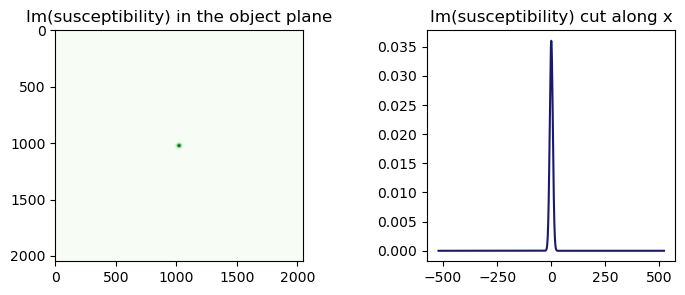

In [5]:
# Initialize scatterer (density * susceptibility)
def gaussian_cloud(thickness):
    """ Thickness here needs to be LESS than the depth of field
    of the imaging system, otherwise a full split-step Helmholtz
    propagator needs to be implemented; here we get away by
    multiplications"""
    # Atomic gaussian density distribution; neglect atom shot noise
    density_dist = np.exp(-(X**2)/(Rx**2) - (Y**2)/(Ry**2))
    return density_dist * χ0

χ = gaussian_cloud(thickness=Rz)

if verbose:
    # What does the cloud look like?
    plt.figure(figsize=(8, 3))
    axim = plt.subplot(121)
    axim.set_title('Im(susceptibility) in the object plane')
    axim.imshow(χ.imag, cmap='Greens', aspect='auto')
    axsl = plt.subplot(122)
    axsl.set_title('Im(susceptibility) cut along x')
    axsl = plt.plot(x/um, χ.imag[Ny // 2], c='midnightblue')
    plt.subplots_adjust(wspace=0.5)

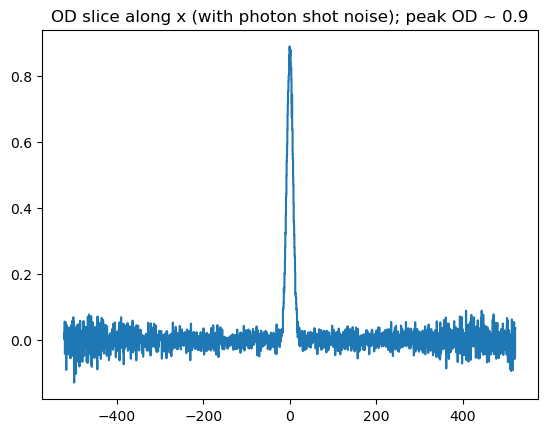

In [6]:
# Compute the scattered field, and fraction right after the cloud
# Use the exact propagator, and assume a thickness of Rz
E_plus = E_minus * np.exp(1j * k0 * χ * Rz)
scattered_fraction = (E_minus - E_plus)/E_minus

if verbose:
    # What is the expected optical depth?
    I_plus, I_minus = field2intensity(E_plus), field2intensity(E_minus)
    od = -np.log((I_plus + photon_shot_noise(I_plus))/
                (I_minus + photon_shot_noise(I_minus)))
    # Slice and average ~20 pixels
    slice_radius = 15
    peak_xOD = np.amax(od[Ny // 2 - slice_radius : Ny // 2 + slice_radius].mean(0))
    plt.title(fR'OD slice along x (with photon shot noise); peak OD ~ {peak_xOD:.1f}')
    plt.step(x/um, od[Ny // 2 - slice_radius : Ny // 2 + slice_radius].mean(0))

In [7]:
# Exit pupil function

# The coefficients are normalized by the aperture's max spatial frequency,
# but their normalized value should be close to the rms phase shift in 
# "normalized-wavenumbers', e.g. if kNA ~ 2*pi*6e5 1/m, then a Z20 = +- 100 
# normalized coefficient implies a defocus of +- (2 * pi * 100 / kNA) ~ +- 166 um

defocus = 1 * mm
Z20 = defocus * kNA / (2*π)

Z00 = 0.0 # Piston
Z1m1 = 0.0 # Vertical tilt
Z11 = 0.0 # Horizontal tilt (tip)
Z2m2 = 0.0 # Oblique astigmatism 
Z22 = 0.0 # Vertical astigmatism
Z20 = Z20 # Longitudinal defocus of ~ 1 mm
Z3m3 = 0.0 # Vertical trefoil
Z3m1 = 0.0 # Vertical coma
Z31 = 0.0 # Horizontal coma
Z33 = 0.0 # Oblique trefoil
Z4m4 = 0.0 # Vertical Tetrafoil
Z4m2 = 0.0 # 2nd order astigmatism
Z40 = 0.0 # Primary spherical #6.2
Z42 = 0.0 # 2nd order astigmatism
Z44 = 0.0 # Oblique Tetrafoil
kR, kT = cart2pol(kX, kY)

# Unit aperture; pad pupil
uR = kR/kNA
mic_aperture = np.ones_like(E_minus)
mic_aperture[uR**2 > 1] = 0.
pupil_amp = mic_aperture

pupil_phase = (Z00 +
              Z11 * 2 * uR * np.cos(kT) +
              Z1m1 * 2 * uR * np.sin(kT) +
              Z22 * np.sqrt(6) * uR**2 * np.cos(2*kT) +
              Z2m2 * np.sqrt(6) * uR**2 * np.sin(2*kT) + 
              Z20 * np.sqrt(3)*(2*uR**2 - 1) + 
              Z3m3 * np.sqrt(8) * uR**3 * np.sin(3*kT) + 
              Z3m1 * np.sqrt(8) * (3 * uR**3 - 2 * uR)*np.sin(kT) +
              Z31 * np.sqrt(8) * (3 * uR**3 - 2 * uR)*np.cos(kT) +
              Z33 * np.sqrt(8) * uR**3 * np.sin(3*kT) +
              Z4m4 * np.sqrt(10)* uR**4 * np.sin(4*kT) +
              Z4m2 * np.sqrt(10) * (4*uR**4 - 3*uR**2)*np.sin(2*kT) + 
              Z40 * (6*uR**4 - 6*uR**2 + 1) +
              Z42 * np.sqrt(10) * (4*uR**4 - 3*uR**2)*np.cos(2*kT) + 
              Z44 * np.sqrt(10)* uR**4 * np.cos(4*kT)
    )

pupil_phase[uR**1 > 1] = 0.
pupil_func = pupil_amp * np.exp(1j * pupil_phase)

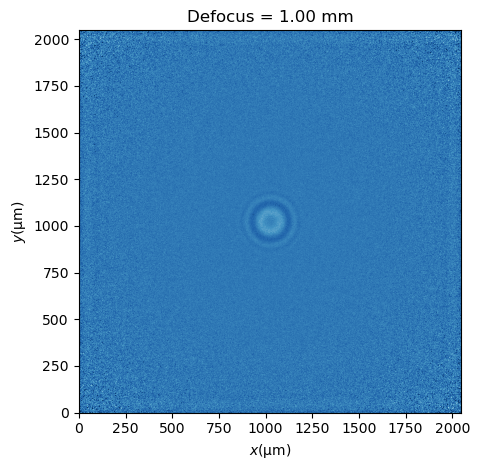

In [8]:
# Apply pupil function to field ratio
transformed_field = np.fft.ifftn(np.fft.fftn(E_plus) * pupil_func)
I_plus = field2intensity(transformed_field)
I_minus = field2intensity(E_minus)
expected_od = -np.log((I_plus+photon_shot_noise(I_plus))/(I_minus+photon_shot_noise(I_minus)))
if verbose:
    # How does the od turn out?
    plt.figure()
    ax = plt.subplot(111)
    ax.imshow(expected_od, cmap='RdBu_r', vmin=-0.25, vmax=1.5, origin='lower')
    ax.set_xlabel(fR'$x ({{\rm \mu m}})$')
    ax.set_ylabel(fR'$y ({{\rm \mu m}})$')
    ax.set_title(fR'Defocus = {defocus/mm:.2f} mm')
    plt.tight_layout()

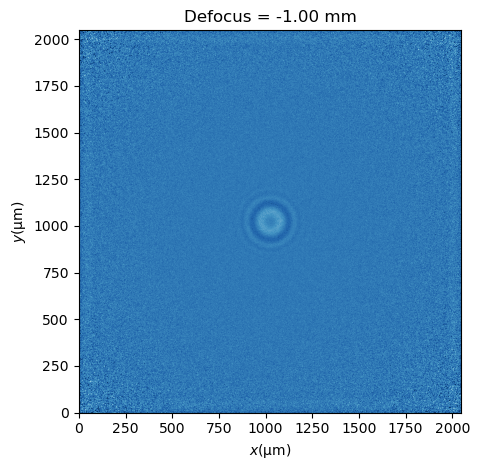

In [9]:
# Apply pupil function to field ratio
transformed_field = np.fft.ifftn(np.fft.fftn(E_plus) * pupil_func.conj())
I_plus = field2intensity(transformed_field)
I_minus = field2intensity(E_minus)
expected_od = -np.log((I_plus+photon_shot_noise(I_plus))/(I_minus+photon_shot_noise(I_minus)))
if verbose:
    # How does the od turn out?
    plt.figure()
    ax = plt.subplot(111)
    ax.imshow(expected_od, cmap='RdBu_r', vmin=-0.25, vmax=1.5, origin='lower')
    ax.set_xlabel(fR'$x ({{\rm \mu m}})$')
    ax.set_ylabel(fR'$y ({{\rm \mu m}})$')
    ax.set_title(fR'Defocus = -{defocus/mm:.2f} mm')
    plt.tight_layout()

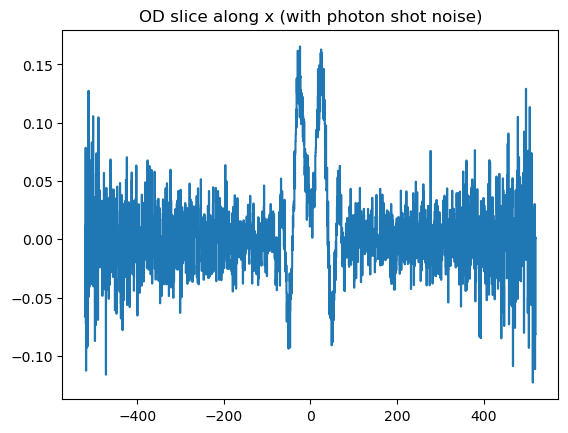

In [10]:
if verbose:
    # Slice and average ~20 pixels
    slice_radius = 15
    plt.title('OD slice along x (with photon shot noise)')
    plt.step(x/um, expected_od[Ny // 2 - slice_radius : Ny // 2 + slice_radius].mean(0))

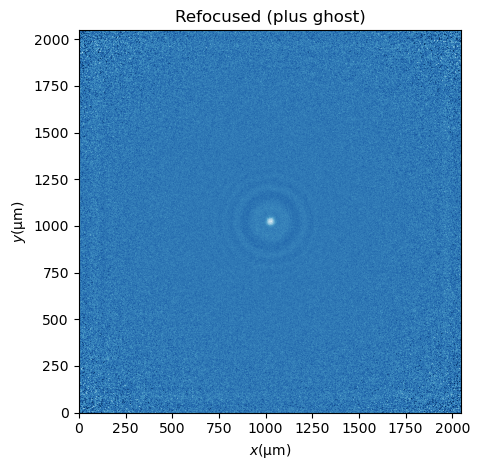

In [11]:
# Deconvolution from intensity
def tikhonov_reg(intensity_image, transf_func, regularization=0.1):
    """ Tikhonov is a regularized pseudoinverse penalizing noise """
    # Note that when we guess the field from intensity, there are two 
    # solutions (one forward/one backward), and in general this approach
    # gives the "correct" answer plus a "ghost" image corresponding to 
    # a forward propagating kernel.
    field_guess = np.sqrt(intensity_image)
    pseudoinv = transf_func.conj() / (transf_func * transf_func.conj() + regularization)
    deconvolved_field = np.fft.ifftn(pseudoinv * np.fft.fftn(field_guess, norm='ortho'), norm='ortho')
    return field2intensity(deconvolved_field) + photon_shot_noise(field2intensity(deconvolved_field))

deconv_Iplus = tikhonov_reg(I_plus, pupil_func, regularization=0.2)
deconv_Iminus = tikhonov_reg(I_minus, pupil_func, regularization=0.2)
deconv_od = -np.log(deconv_Iplus/deconv_Iminus)
if verbose:
    # How does the od turn out?
    plt.figure()
    ax = plt.subplot(111)
    ax.imshow(deconv_od, cmap='RdBu_r', vmin=-0.25, vmax=1.5, origin='lower')
    ax.set_xlabel(fR'$x ({{\rm \mu m}})$')
    ax.set_ylabel(fR'$y ({{\rm \mu m}})$')
    ax.set_title(fR'Refocused (plus ghost)')
    plt.tight_layout()

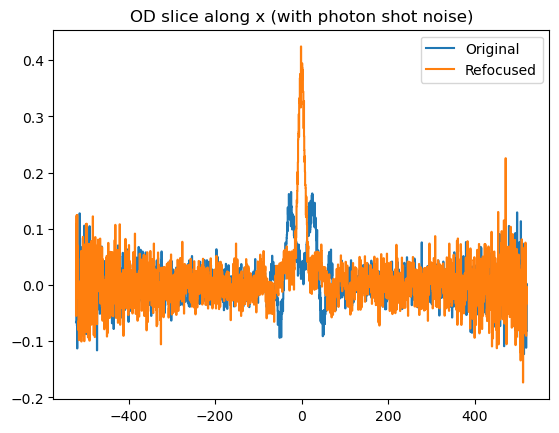

In [12]:
if verbose:
    # Slice and average ~20 pixels
    slice_radius = 15
    plt.title('OD slice along x (with photon shot noise)')
    plt.step(x/um, expected_od[Ny // 2 - slice_radius : Ny // 2 + slice_radius].mean(0), label='Original')
    plt.step(x/um, deconv_od[Ny // 2 - slice_radius : Ny // 2 + slice_radius].mean(0), label='Refocused')
    plt.legend()